<h3><center>Introduction</center></h3>
<div style="font-family:verdana; word-spacing:1.7px;">
    The CrowdSource team at Google Research, a group dedicated to advancing NLP and other types of ML science via crowdsourcing, has collected data on a number of quality scoring aspects.
<br><br>
In this Kernel, we will use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion.<br><br>
    </div>

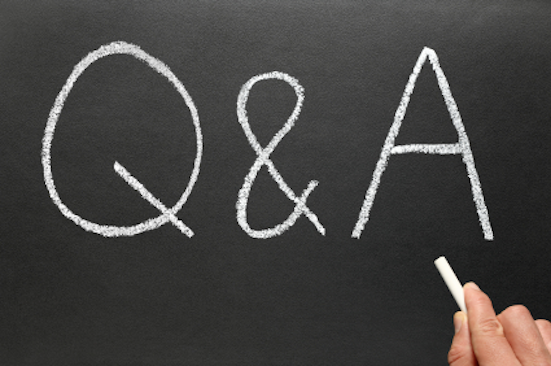

<h3><center>1. Importing Libraries</center></h3>

In [ ]:
!pip install -q textstat

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import os
import gc

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles 
import matplotlib.pyplot as plt 
import seaborn as sns

import plotly.offline as plty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from scipy import stats
import textstat

from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil

from wordcloud import WordCloud, STOPWORDS


<h3><center>2. Reading Files</center></h3>

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
PATH = '/kaggle/input/google-quest-challenge/'

train_df = pd.read_csv(f'{PATH}train.csv')
test_df = pd.read_csv(f'{PATH}test.csv')

<h3><center>3. Exploring Data</center></h3>

In [ ]:
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [ ]:
DataDesc(train_df)[:10]

The data looks pretty clean with no missing values.

In [ ]:
DataDesc(test_df)[:10]

<h3>Target Columns</h3>

In [ ]:
sub_df = pd.read_csv(f'{PATH}sample_submission.csv')
target_cols = train_df[train_df.columns[train_df.columns.isin(sub_df.columns[1:])]].columns

In [ ]:
target_cols

In [ ]:
train_df.host[:5]

In [ ]:
train_df.category.value_counts()

Splitting and fetching first string to indentfiy the category

In [ ]:
train_df['host_cat'] = train_df['host'].apply(lambda x : x.split('.')[0])
train_df.drop(['host'], axis=1, inplace=True)

In [ ]:
host = train_df.groupby(['host_cat'])['url'].nunique().sort_values(ascending=False)
category = train_df.groupby(['category'])['url'].nunique().sort_values(ascending=False)

plt.figure(figsize=(16,12))
plt.suptitle('Unique URL by Host and Categories', size=22)

plt.subplot(211)
g0 = sns.barplot(x=category.index, y=category.values, color='blue')
g0.set_title("Unique Answers by category", fontsize=22)
g0.set_xlabel("Category Name", fontsize=19)
g0.set_ylabel("Total Count", fontsize=19)
#g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
for p in g0.patches:
    height = p.get_height()
    g0.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/category.sum()*100),
            ha="center",fontsize=11) 

plt.subplot(212)
g1 = sns.barplot(x=host[:20].index, y=host[:20].values, color='blue')
g1.set_title("TOP 20 HOSTS with more UNIQUE questions", fontsize=22)
g1.set_xlabel("Host Name", fontsize=19)
g1.set_ylabel("Total Count", fontsize=19)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/host.sum()*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.3, top = 0.90)

plt.show()

In [ ]:
plt.figure(figsize=(12,8))

venn2([set(train_df['question_user_name'].values), 
       set(train_df['answer_user_name'].values)],
      set_labels=('Question Users', 'Answer Users'), alpha=.5)

plt.title('Comparison of Question and Answer Users Intersection\n', fontsize=20)

plt.show()

* We can see that 405 users have played role in both questioning & answering sessions.
* We have more users who have answered than the questions asked as multiple users might have responded

In [ ]:
import matplotlib.gridspec as gridspec # to do the grid of plots

grid = gridspec.GridSpec(3, 3)
plt.figure(figsize=(16,3*4))

plt.suptitle('Intersection QA USERS \nQuestions and Answers by different CATEGORIES', size=20)

for n, col in enumerate(set(train_df['category'].values)):
    ax = plt.subplot(grid[n])
    venn2([set(train_df[train_df.category == col]['question_user_name'].values), 
           set(train_df[train_df.category == col]['answer_user_name'].values)],
      set_labels=('Question Users', 'Answer Users'), )
    ax.set_title(str(col), fontsize=15)
    ax.set_xlabel('')
    #plt.subplots_adjust(top = 0.98, wspace=.9, hspace=.9)
    
plt.subplots_adjust(top = 0.9, hspace=.1)

plt.show()

In [ ]:
grid = gridspec.GridSpec(5, 3)
plt.figure(figsize=(16,5*4))

top_cat = train_df['host_cat'].value_counts(ascending=False).index[:15]

plt.suptitle('Intersection QA USERS \nQuestions and Answers by different Host Categories', size=20)

for n, col in enumerate(top_cat):
    ax = plt.subplot(grid[n])
    venn2([set(train_df[train_df.host_cat == col]['question_user_name'].values), 
           set(train_df[train_df.host_cat == col]['answer_user_name'].values)],
      set_labels=('Question Users', 'Answer Users'), )
    ax.set_title(str(col), fontsize=15)
    ax.set_xlabel('')
    #plt.subplots_adjust(top = 0.98, wspace=.9, hspace=.9)
    
plt.subplots_adjust(top = 0.9, hspace=.1)

plt.show()

<h3>No of Words in body</h3>

In [ ]:
question_body_tokens = [word_tokenize(question) for question in train_df.question_body.values]

len_words = []

for i in range(len(question_body_tokens)):
    len_words.append(len(question_body_tokens[i]))
    
# Create a new feature for the lengh of each review
train_df['question_n_words'] = len_words

In [ ]:
grid = gridspec.GridSpec(5, 3)
plt.figure(figsize=(16,6*4))

plt.suptitle('Title and Question Lenghts by Different Categories \nThe Mean in RED - Also 5% and 95% lines', size=20)
count=0
top_cats=train_df['category'].value_counts().index
for n, col in enumerate(top_cats):
    for i, q_t in enumerate(['question_title', 'question_body', 'question_n_words']):
        ax = plt.subplot(grid[count])
        if q_t == 'question_n_words':
            sns.distplot(train_df[train_df['category'] == col][q_t], bins = 50, 
                         color='g', label="RED - 50%") 
            ax.set_title(f"Distribution of {str(col)} \nQuestion #Total Words Distribution", fontsize=15)
            ax.axvline(train_df[train_df['category'] == col][q_t].quantile(.95))
            ax.axvline(train_df[train_df['category'] == col][q_t].quantile(.05))
            mean_val = train_df[train_df['category'] == col][q_t].mean()
            ax.axvline(mean_val, color='red' )
            ax.set_xlabel('')            
        else:
            sns.distplot(train_df[train_df['category'] == col][q_t].str.len(), bins = 50, 
                         color='g', label="RED - 50%") 
            ax.set_title(f"Distribution of {str(col)} \n{str(q_t)}", fontsize=15)
            ax.axvline(train_df[train_df['category'] == col][q_t].str.len().quantile(.95))
            ax.axvline(train_df[train_df['category'] == col][q_t].str.len().quantile(.05))
            mean_val = train_df[train_df['category'] == col][q_t].str.len().mean()
            ax.axvline(mean_val, color='red' )
            #ax.text(x=mean_val*1.1, y=.02, s='Holiday in US', alpha=0.7, color='#334f8d')
            ax.set_xlabel('')
        count+=1
        
plt.subplots_adjust(top = 0.90, hspace=.4, wspace=.15)
plt.show()

<h3>Distribution of Target Features</h3>

In [ ]:
grid = gridspec.GridSpec(10, 3)

plt.figure(figsize=(16,8*4))
count=0
plt.suptitle('Distribution of QA metrics (Target Features)', size=20)
# top_host = df_train['host_cat'].value_counts()[:15].index
for n, col in enumerate(target_cols):
    #if df_train[target_cols].std()[col] > .15:
    ax = plt.subplot(grid[count])
    sns.boxplot(x='category', y=col, data=train_df)
    ax.set_title(str(col), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)

plt.show()

<h3>Correlation Between Features</h3>

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(train_df[target_cols].corr(),vmin=-1,cmap='YlGnBu')

<div style="font-family:verdana; word-spacing:1.7px;">
We could see high correlation between Answer(Instructions,procedure,explanation) & Question(Instructions,procedure,explanation) respectively
    </div>

<h3>Question & Answer Texts</h3>

In [ ]:
stopwords = set(STOPWORDS)
newStopWords = ['amp', 'gt', 'lt', 'div', 'id',
                'fi', 'will', 'use', 'one', 'nbsp', 'need']
stopwords.update(newStopWords)

grid = gridspec.GridSpec(5, 2)

plt.figure(figsize=(16,7*4))

plt.suptitle('Word Cloud OF CATEGORY FEATURE', size=20)

for n, col in enumerate(train_df['category'].value_counts().index):
    ax = plt.subplot(grid[n])  
    
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[train_df['category'] == col]['answer'].astype(str)))

    #print(wordcloud)

    plt.imshow(wordcloud)
    plt.title(f"Category: {col}",fontsize=18)
    plt.axis('off')
plt.subplots_adjust(top = 0.95, hspace=.2, wspace=.1 )

plt.show()

In [ ]:
grid = gridspec.GridSpec(5, 2)

plt.figure(figsize=(16,7*4))

plt.suptitle('Answers Word Cloud \nTOP 10 hosts with more questions', size=20)

for n, col in enumerate(train_df['host_cat'].value_counts()[:10].index):
    ax = plt.subplot(grid[n])   
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[train_df['host_cat'] == col]['answer'].astype(str)))

    #print(wordcloud)

    plt.imshow(wordcloud)
    plt.title(f"Host: {col}",fontsize=18)
    plt.axis('off')
    
plt.subplots_adjust(top = 0.95, hspace=.2, wspace=.1 )

plt.show()

<h3>Sentiment Analysis</h3>

In [ ]:
def polarity(text):
    if type(text) == str:
        return SIA.polarity_scores(text)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
train_df["ans_polarity"] = train_df["answer"].progress_apply(polarity)

Calculate mean Sentiment values

In [ ]:
# Calculate mean values of Sentiments
neg_vals, pos_vals, neutral_vals = [], [], []

for x_dict in train_df["ans_polarity"].values:
    neg_vals.append(x_dict['neg'])
    pos_vals.append(x_dict['pos'])
    neutral_vals.append(x_dict['neu'])

neg_vals = np.asarray(neg_vals)
pos_vals = np.asarray(pos_vals)
neutral_vals = np.asarray(neutral_vals)

mean_neg = neg_vals.mean()
mean_pos = pos_vals.mean()
mean_neu = neutral_vals.mean()

Negative Sentiment

In [ ]:
neg_pol = [pols['neg'] for pols in train_df["ans_polarity"] if type(pols) is dict]
neg_pol = list(filter((0.0).__ne__, neg_pol))



trace = go.Histogram(x=neg_pol, marker=dict(
            color='lightseagreen')
    )
data = [trace]

layout = go.Layout(

    shapes= [{'line': {'color': '#FF0000', 'dash': 'solid', 'width': 1},
        'type': 'line',
        'x0': mean_neg,
        'x1': mean_neg,
        'xref': 'x',
        'y0': -0.1,
        'y1': 1,
        'yref': 'paper'}],

    # Annotations
    annotations=[dict(x=mean_neg,
                y=1,
                xref='x',
                yref='paper',
                text=f"Mean a = {np.round(mean_neg,3)}",
                showarrow=True,
                arrowhead=7,
                ax=1,
                ay=1,
            )]
)
fig = go.Figure(data=data, layout=layout)



fig.update_layout(xaxis_title="Negativity sentiment", 
                  title_text="Negativity sentiment", template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
From the above plot, we can see that negative sentiment has a strong rightward (positive) skew, indicating that negativity is usually on the lower side. This suggests that most comments are not toxic or negative. In fact, the most common negativity value is around <b>0.036</b>. Virtually no comments have a negativity greater than 0.35
    </div>

Positive Sentiment

In [ ]:
pos_pol = [pols['pos'] for pols in train_df["ans_polarity"] if type(pols) is dict]
pos_pol = list(filter((0.0).__ne__, pos_pol))



trace = go.Histogram(x=pos_pol, marker=dict(
            color='lightsalmon')
    )
data = [trace]

layout = go.Layout(

    shapes= [{'line': {'color': 'seagreen', 'dash': 'solid', 'width': 1},
        'type': 'line',
        'x0': mean_pos,
        'x1': mean_pos,
        'xref': 'x',
        'y0': -0.1,
        'y1': 1,
        'yref': 'paper'}],

    # Annotations
    annotations=[dict(x=mean_pos,
                y=1,
                xref='x',
                yref='paper',
                text=f"Mean a = {np.round(mean_pos,3)}",
                showarrow=True,
                arrowhead=7,
                ax=1,
                ay=1,
            )]
)
fig = go.Figure(data=data, layout=layout)



fig.update_layout(xaxis_title="Positivity sentiment", 
                  title_text="Positivity sentiment", template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
After comparing with Negativity, the answers have slightly greater positivity
    </div>

In [ ]:
neu_pol = [pols['neu'] for pols in train_df["ans_polarity"] if type(pols) is dict]
neu_pol = list(filter((0.0).__ne__, neu_pol))



trace = go.Histogram(x=neu_pol, marker=dict(
            color='lightskyblue')
    )
data = [trace]

layout = go.Layout(

    shapes= [{'line': {'color': 'lightsalmon', 'dash': 'solid', 'width': 1},
        'type': 'line',
        'x0': mean_neu,
        'x1': mean_neu,
        'xref': 'x',
        'y0': -0.1,
        'y1': 1,
        'yref': 'paper'}],

    # Annotations
    annotations=[dict(x=mean_neu,
                y=1,
                xref='x',
                yref='paper',
                text=f"Mean a = {np.round(mean_neu,3)}",
                showarrow=True,
                arrowhead=7,
                ax=1,
                ay=1,
            )]
)
fig = go.Figure(data=data, layout=layout)



fig.update_layout(xaxis_title="Neutral sentiment", 
                  title_text="Neutral sentiment", template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
    It is clear that as positivity & Negativity are low we have high neutral answers with mean value 0.88
    </div>

<h3>Readability</h3>
<div style="font-family:verdana; word-spacing:1.7px;">
Readability is an indication of how "easy" it is to read some text. There are several metrics that can be used to measure the readability of a piece of text, including Flesch reading ease, automated readability, and Dale-Chall readability.
    </div>

In [ ]:
train_df["flesch_reading_ease"] = train_df["answer"].progress_apply(textstat.flesch_reading_ease)
#train_df["automated_readability"] = train_df["answer"].progress_apply(textstat.automated_readability_index)
#train_df["dale_chall_readability"] = train_df["answer"].progress_apply(textstat.dale_chall_readability_score)

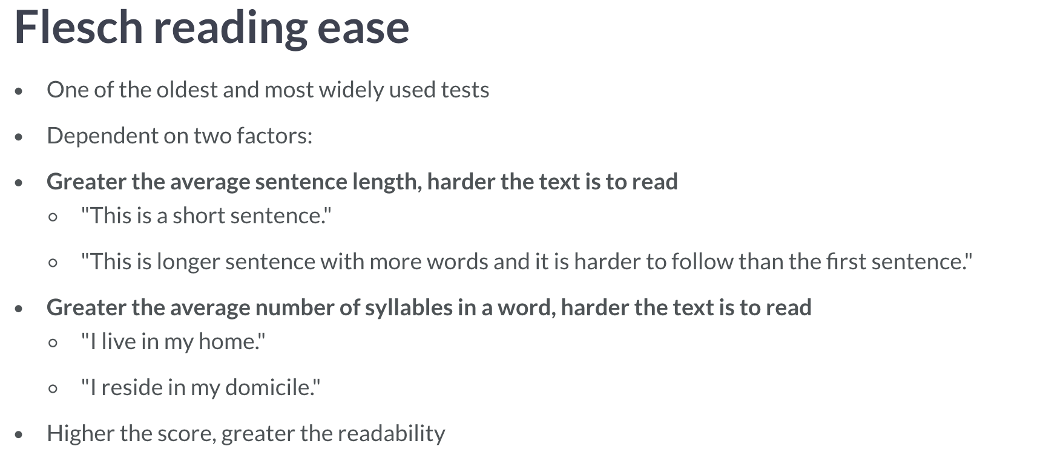

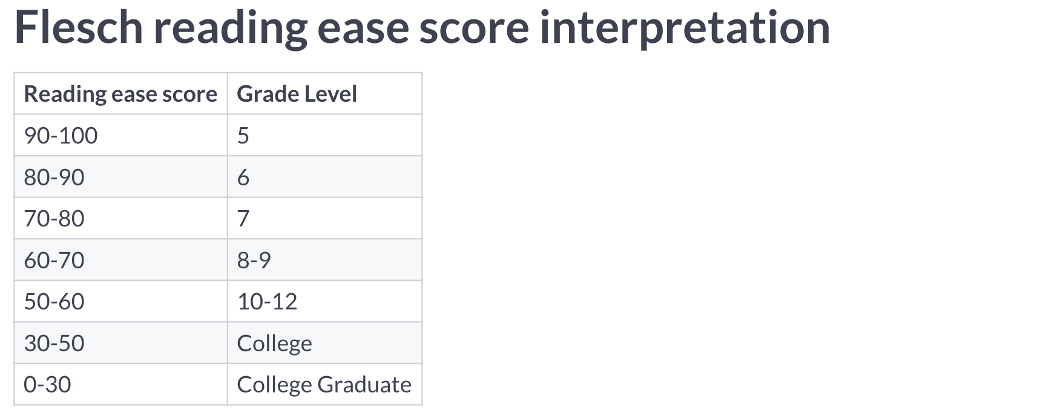

In [ ]:
fig = go.Figure(go.Histogram(x=train_df.query("flesch_reading_ease > 0")["flesch_reading_ease"], marker=dict(
            color='darkorange')
    ))

fig.update_layout(xaxis_title="Flesch reading ease", title_text="Flesch reading ease", 
                  template="simple_white")
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
    We have a Gaussian Distribution of Scores ranging from very simple to complex readablity, Let's have a deeper look into the reading scores of different categories to understand more clearly
    </div>

In [ ]:
fig = go.Figure()

for category, color in zip(set(train_df['category'].values), ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']):
    fig.add_trace(go.Histogram(name = category, x=train_df.query(f"flesch_reading_ease > 0 and category == '{category}'")["flesch_reading_ease"], marker=dict(
                color=color)))
    

fig.update_layout(xaxis_title="Flesch reading ease", title_text="Flesch reading ease", 
                  template="simple_white", barmode='overlay')

fig.update_traces(opacity=0.6)
fig.show()

<div style="font-family:verdana; word-spacing:1.7px;">
All the different categories show similar distribution indicating that the answers given do not have fixed complexity based on category.
    </div>

<h3>Preprocessing </h3>

In [ ]:
train_df.columns

In [ ]:
extra_cols = ['host_cat', 'question_n_words', 'ans_polarity', 'flesch_reading_ease']

y_train = train_df[target_cols].copy()
X_train = train_df.drop(list(extra_cols) + list(target_cols), axis=1)
del train_df

X_test = test_df.copy()
del test_df

gc.collect()

<h3><center>4. Bert Tokenizer</center></h3>

In [ ]:
from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer


np.set_printoptions(suppress=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

save_path = '/kaggle/working/bert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

'''fast_tokenizer = BertWordPieceTokenizer('bert_base_uncased/vocab.txt', 
                                        lowercase=True)'''

fast_tokenizer = BertTokenizer('bert_base_uncased/vocab.txt', 
                                        lowercase=True)


<h3>Preprocessing Data to Bert Architecture</h3>

In [ ]:
MAX_SEQUENCE_LENGTH = 512

def _convert_to_transformer_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    input_ids_q, input_masks_q, input_segments_q = return_id(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_a, input_masks_a, input_segments_a = return_id(
        answer, None, 'longest_first', max_sequence_length)
    
    return [input_ids_q, input_masks_q, input_segments_q,
            input_ids_a, input_masks_a, input_segments_a]

# Computing the inputs
def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    
    input_ids_q, input_masks_q, input_segments_q = [], [], []
    input_ids_a, input_masks_a, input_segments_a = [], [], []
    
    for _, instance in tqdm(df[columns].iterrows()):
        
        t, q, a = instance.question_title, instance.question_body, instance.answer

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = \
        _convert_to_transformer_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_q.append(ids_q)
        input_masks_q.append(masks_q)
        input_segments_q.append(segments_q)

        input_ids_a.append(ids_a)
        input_masks_a.append(masks_a)
        input_segments_a.append(segments_a)
        
    return [np.asarray(input_ids_q, dtype=np.int32), 
            np.asarray(input_masks_q, dtype=np.int32), 
            np.asarray(input_segments_q, dtype=np.int32),
            np.asarray(input_ids_a, dtype=np.int32), 
            np.asarray(input_masks_a, dtype=np.int32), 
            np.asarray(input_segments_a, dtype=np.int32)]


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

<h3><center>5. Creating Model</center></h3>

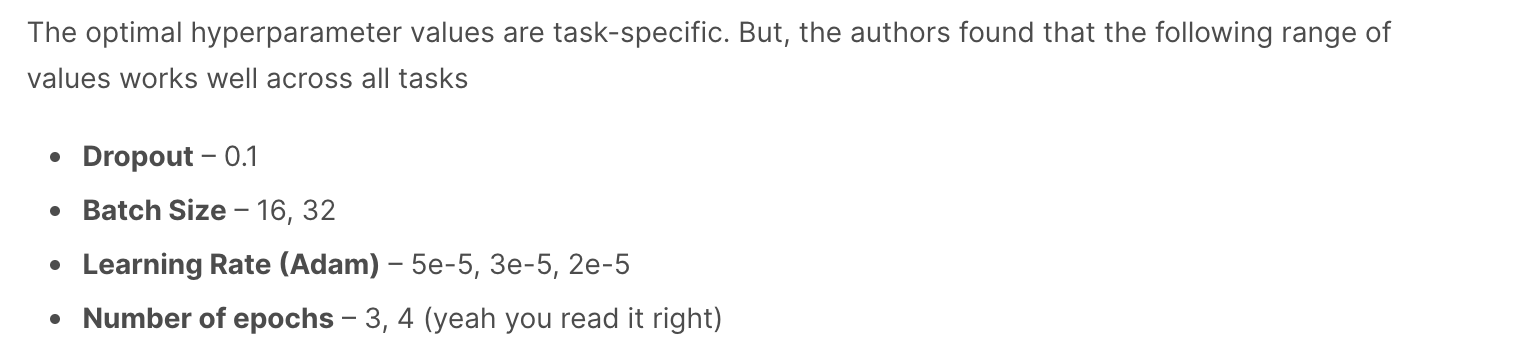

In [ ]:
## Computing the error metric to the model optimization
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

def create_model():
    q_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    #config = BertConfig() # print(config) to see settings
    #config.output_hidden_states = False # Set to True to obtain hidden states
    # caution: when using e.g. XLNet, XLNetConfig() will automatically use xlnet-large config
    
    # normally ".from_pretrained('bert-base-uncased')", but because of no internet, the 
    # pretrained model has been downloaded manually and uploaded to kaggle. 
    
    
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    q_embedding = bert_model(q_id, attention_mask=q_mask, 
                             token_type_ids=q_atn)[0]
    a_embedding = bert_model(a_id, attention_mask=a_mask, 
                             token_type_ids=a_atn)[0]
    
    q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    
    x = tf.keras.layers.Concatenate()([q, a])
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(30, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[q_id, q_mask, q_atn, a_id, a_mask, a_atn,], outputs=x)
    
    return model

In [ ]:
outputs = compute_output_arrays(y_train, y_train.columns)

inputs = compute_input_arrays(X_train, X_train.columns, 
                              fast_tokenizer, MAX_SEQUENCE_LENGTH)

test_inputs = compute_input_arrays(X_test, X_test.columns, 
                                   fast_tokenizer, MAX_SEQUENCE_LENGTH)

<h3><center>6. Training Model</center></h3>

In [ ]:
## Creating Kfold with 10 splits 
gkf = GroupKFold(n_splits=10).split(X=X_train.question_body, groups=X_train.question_body)

## to receive predictions
valid_preds = []
test_preds = []

## Looping throught the folds
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    # Train for particular folds(used for training for less folds for testing)
    if fold in np.arange(10):  #[0, 1, 2]
        
        ## Train index from Kfold 
        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]
        ## Valid index from Kfold 
        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]
        
        K.clear_session()
        
        ## Instantiating the Bert Model
        model = create_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        ## Fiting the model
        model.fit(train_inputs, train_outputs, epochs=2, batch_size=6)
        
        # model.save_weights(f'bert-{fold}.h5')
        valid_preds.append(model.predict(valid_inputs))
        # predicting the test set and appending to test_preds
        test_preds.append(model.predict(test_inputs))
        
        # Calculating the error in the valid set
        rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
        print('validation score = ', rho_val)

<h3><center>7. Predicting Data</center></h3>

In [ ]:
columns = list(y_train.columns)
y = valid_outputs[:10]
y_pred = model.predict(valid_inputs)

In [ ]:
print('Actual output')
pd.DataFrame(data=y, columns=columns)

In [ ]:
print('Predicted output')
pd.DataFrame(data=y_pred[:10], columns=columns)